# Predicting Peptide Binding based on Peptide Sequence

### Load analyzed phage display data

In [3]:
import pandas as pd
import numpy as np
#import sys
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

filepath = '/Users/data.xlsx'

flank_seq1 = 'DEAHANK' 
flank_seq2 = 'MAHAL'
flank_seq_len = 23
drop_fix_aa_loc = [1,4,5,7,8,10,13,16,17,20,21] # concensus aa positions

select_round1 = 'Percentage_S/N_Neg2_R4_amp'

Thresh = 2 # threshold for grouping S/N into Good, Neutral, Bad

####################################
## extracting features and labels ##
####################################
data = pd.read_excel(filepath, header=0)
data['var_seq'] = data['Peptide'].str.extract(flank_seq1+'(.*)'+flank_seq2, expand=False) # extracting just the variable portion. Or '(.+?)'
# select only the right seq length, this is important for generating fasta file
data = data.loc[data.var_seq.str.len() == flank_seq_len,]

aa_label = {'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20,'O':21}

s_data = data.loc[data[select_round1] >= 0, [select_round1, 'var_seq']] # subset the data

### Take a quick look at the S/N distribution before we subset them into different labels

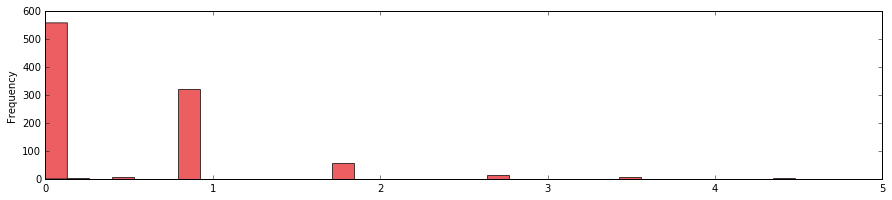

In [4]:
plt.rcParams['figure.figsize'] = (15.0, 3.0)
s_data[select_round1].plot(colormap='Set1', kind='hist', alpha=0.7, bins=100, xlim=(0,5)) 

Seems like there are several groups, we can further separate them based on the Threshold me choose.

Based on my phage display experience, S/N > 2 may be considered as good binding peptide. 
So I will separate them into Bad (0-0.5), Neutral (0.5-2), and Good (>2)

In [5]:
# (instead of directly using S/N ratio) re-define 'label': Good (1), Neutral (0), Bad (-1)
idx_Good = s_data[select_round1] > Thresh
idx_Neutral = (s_data[select_round1] <= Thresh) & (s_data[select_round1] > 1/Thresh)
idx_Bad = (s_data[select_round1] <= 1/Thresh) & (s_data[select_round1] >=0.0 )

# create a new Label for above groups
s_data.loc[idx_Good, 'Label'] = 1
s_data.loc[idx_Neutral, 'Label'] = 0
s_data.loc[idx_Bad, 'Label'] = -1

### Take a quick look at the S/N distribution in each group

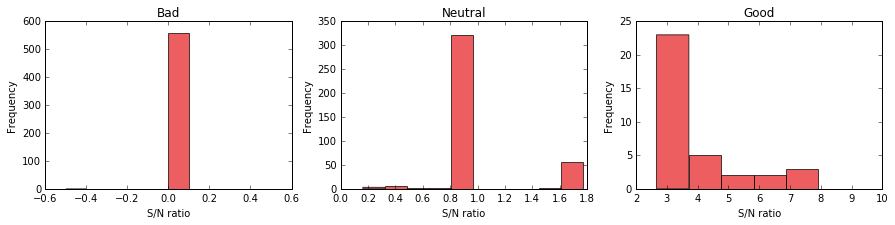

In [6]:
p_Good = s_data.loc[idx_Good, select_round1]
p_Neutral = s_data.loc[idx_Neutral, select_round1]
p_Bad = s_data.loc[idx_Bad, select_round1]

df = pd.concat([p_Good, p_Neutral, p_Bad], axis=1)
df.columns = ['Good', 'Neutral', 'Bad']

# Hist within each group
plt.rcParams['figure.figsize'] = (15.0, 3.0)
fig, axes = plt.subplots(nrows=1, ncols=3)
df.Good.plot(kind='hist', colormap='Set1', ax=axes[2], xlim=(Thresh,10), alpha=0.7); axes[2].set_title('Good'); axes[2].set_xlabel("S/N ratio")
df.Neutral.plot(kind='hist', colormap='Set1', ax=axes[1], alpha=0.7); axes[1].set_title('Neutral'); axes[1].set_xlabel("S/N ratio")
df.Bad.plot(kind='hist', colormap='Set1', ax=axes[0], alpha=0.7); axes[0].set_title('Bad'); axes[0].set_xlabel("S/N ratio")

Our threshold boundary does a good job in separating three S/N populations. (One may argue that in Neutral group, there is a small population that may fit into Good. But based on my experience those can not be considered as Good binders.)

**However, we have a lot more data points in Bad > Neutral >> Good.** This will bias our training, so we need to re-sample Bad and Neutral so that they have equal amount of data points.

### Re-sample Bad and Neutral to get similar sample size as Good

In [7]:
s_data.re_g = s_data.loc[idx_Good]
s_data.re_n = s_data.loc[idx_Neutral].sample(n=len(s_data.re_g)*2, random_state=42)
s_data.re_b = s_data.loc[idx_Bad].sample(n=len(s_data.re_g)*2, random_state=42)
print 'The Sample Size in Good   : ', len(s_data.re_g)
print 'The Sample Size in Neutral: ', len(s_data.re_n)
print 'The Sample Size in Bad    : ', len(s_data.re_b)

The Sample Size in Good   :  36
The Sample Size in Neutral:  72
The Sample Size in Bad    :  72


### Do these groups have distinct features in their amino acid positions?

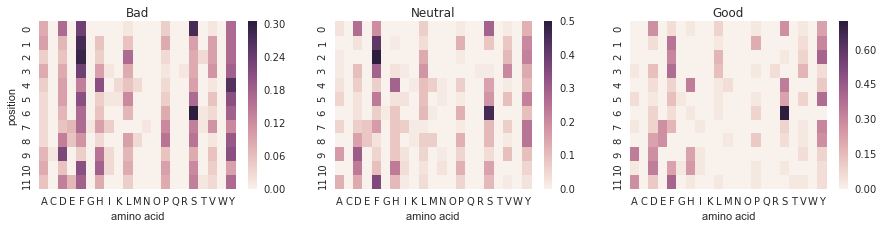

In [9]:
import sys
sys.path.append('/Users/') # where I define my custom functions
from phage_display_funcs import make_seq_heatmap_df
import seaborn as sns 
p3 = make_seq_heatmap_df(s_data.re_g.var_seq, flank_seq_len, drop_fix_aa_loc)
p2 = make_seq_heatmap_df(s_data.re_n.var_seq, flank_seq_len, drop_fix_aa_loc)
p1 = make_seq_heatmap_df(s_data.re_b.var_seq, flank_seq_len, drop_fix_aa_loc)

plt.rcParams['figure.figsize'] = (15.0, 3.0)
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
sns.heatmap(p3, ax=ax3); ax3.set_title('Good'); ax3.set_xlabel('amino acid')
sns.heatmap(p2, ax=ax2); ax2.set_title('Neutral'); ax2.set_xlabel('amino acid')
sns.heatmap(p1, ax=ax1); ax1.set_title('Bad'); ax1.set_xlabel('amino acid'); ax1.set_ylabel('position')

Seems like there is a 'slight' different pattern among them. Let's see how well we can train the machine to recognize the pattern.

### Generate Features and Labels

In [10]:
# append them together
s_data.re = s_data.re_g.append([s_data.re_n, s_data.re_b])
seqs = s_data.re.var_seq 

# converting aa seq into number as shown in aa_label
seq_feature = []
for seq in seqs:
    string = pd.Series(list(seq))
    string.drop(drop_fix_aa_loc, inplace=True) # remove concensus aa
    string.reset_index(drop=True, inplace=True) # reset the index for the next step
    for index, charc in enumerate(string):
        string[index] = aa_label[charc]
    seq_feature.append(string)

seq_label = s_data.re.Label.reset_index(drop=True)

print '# features: ', len(seq_feature)
print '# labels: ', len(seq_label)

# features:  180
# labels:  180


### Split Training and Testing datasets

In [11]:
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(seq_feature, seq_label, test_size=0.15, random_state=42)
print '# of data in trained features: %d' %len(features_train)
print '# of data in test features: %d' %len(features_test)
print '# of data in trained labels: %d' %len(labels_train)
print '# of data in test labels: %d' %len(labels_test)

# of data in trained features: 153
# of data in test features: 27
# of data in trained labels: 153
# of data in test labels: 27


(well..the sample size if very small... Phage Display on Cell is not an easy work..still collecting more data)

### Try _SVM_

**C**, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly.

**gamma** defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.

Proper choice of C and gamma is critical to the SVM’s performance. One is advised to use [sklearn.model_selection.GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) with C and gamma spaced exponentially far apart to choose good values.

In [12]:
from sklearn.svm import SVC
t0 = time() 
clf = SVC(kernel="linear", C=1e1, gamma=1e3) # linear, rbf, poly
clf.fit(features_train, labels_train)
print "training time:", round(time()-t0, 3), "s" # time the training process
score = clf.score(features_test, labels_test)
print "accuracy: ", round(score, 2) # print out the scores

training time: 1.019 s
accuracy:  0.74


In [13]:
# checking the predicted data
labels_test = np.array(labels_test)
idx_test_g = labels_test == 1
#idx_pred = clf.predict(features_test) >0
print "Test Label - Good  :", labels_test[idx_test_g]
print "The prediction says:",  clf.predict(features_test)[idx_test_g]

idx_test_n = labels_test == 0
#idx_pred = clf.predict(features_test) >0
print "Test Label -Neutral:", labels_test[idx_test_n]
print "The prediction says:",  clf.predict(features_test)[idx_test_n]

idx_test_b = labels_test == -1
#idx_pred = clf.predict(features_test) >0
print "Test Label - Bad   :", labels_test[idx_test_b]
print "The prediction says:",  clf.predict(features_test)[idx_test_b]

Test Label - Good  : [ 1.  1.  1.  1.  1.  1.]
The prediction says: [ 0.  0.  1.  1.  0. -1.]
Test Label -Neutral: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
The prediction says: [ 0.  0.  0.  0.  0.  1.  0.  0.  0. -1.  0.]
Test Label - Bad   : [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
The prediction says: [-1. -1. -1. -1. -1.  0. -1. -1. -1. -1.]


### Try _Decision Tree_

In [14]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=1000, max_depth=10, min_samples_split=2, random_state=0)
t0 = time() 
clf.fit(features_train, labels_train)
print "training time:", round(time()-t0, 3), "s" # time the training process
score = clf.score(features_test, labels_test)
print "accuracy: ", round(score, 2) # print out the score

training time: 1.918 s
accuracy:  0.63


In [15]:
# checking the predicted data
labels_test = np.array(labels_test)
idx_test_g = labels_test == 1
#idx_pred = clf.predict(features_test) >0
print "Test Label - Good  :", labels_test[idx_test_g]
print "The prediction says:",  clf.predict(features_test)[idx_test_g]

idx_test_n = labels_test == 0
#idx_pred = clf.predict(features_test) >0
print "Test Label -Neutral:", labels_test[idx_test_n]
print "The prediction says:",  clf.predict(features_test)[idx_test_n]

idx_test_b = labels_test == -1
#idx_pred = clf.predict(features_test) >0
print "Test Label - Bad   :", labels_test[idx_test_b]
print "The prediction says:",  clf.predict(features_test)[idx_test_b]

Test Label - Good  : [ 1.  1.  1.  1.  1.  1.]
The prediction says: [ 0. -1.  1.  0. -1. -1.]
Test Label -Neutral: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
The prediction says: [ 0.  0.  0.  0. -1.  1.  0.  1.  0.  0. -1.]
Test Label - Bad   : [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
The prediction says: [-1. -1. -1. -1. -1.  0. -1. -1. -1. -1.]


### Try _AdaBoost_

In [16]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100)
t0 = time() 
clf.fit(features_train, labels_train)
print "training time:", round(time()-t0, 3), "s" # time the training process
score = clf.score(features_test, labels_test)
print "accuracy: ", round(score, 2) # print out the score

training time: 0.205 s
accuracy:  0.52


In [17]:
# checking the predicted data
labels_test = np.array(labels_test)
idx_test_g = labels_test == 1
#idx_pred = clf.predict(features_test) >0
print "Test Label - Good  :", labels_test[idx_test_g]
print "The prediction says:",  clf.predict(features_test)[idx_test_g]

idx_test_n = labels_test == 0
#idx_pred = clf.predict(features_test) >0
print "Test Label -Neutral:", labels_test[idx_test_n]
print "The prediction says:",  clf.predict(features_test)[idx_test_n]

idx_test_b = labels_test == -1
#idx_pred = clf.predict(features_test) >0
print "Test Label - Bad   :", labels_test[idx_test_b]
print "The prediction says:",  clf.predict(features_test)[idx_test_b]

Test Label - Good  : [ 1.  1.  1.  1.  1.  1.]
The prediction says: [ 0.  0.  1.  0.  0. -1.]
Test Label -Neutral: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
The prediction says: [ 0.  0.  0.  0. -1.  1.  0.  1. -1.  1. -1.]
Test Label - Bad   : [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
The prediction says: [-1. -1. -1. -1.  0. -1.  0. -1. -1. -1.]


## Final Thought on this dataset

**SVM** gives me the best Score **0.73**

Number of Training points: **153**

Number of Testing points : **27**

### How to get better prediction?
It's not easy to quickly see any pattern in the above heatmap. That already tells us that the feature is not good enough. I can get better distinction by increasing the Threshold > 3 or even 5, but then I loose the sample size in Good population. So to get better prediction:

1. Increase the sample quality, get good distinction between Good and Bad binders
    - (The current sample is collected from phage library + target cells direct incubation. We found out this method gave us a lot of non-specific binding, therefore it's very hard to collect good S/N binders. Our current thought on improving the quality is to re-design the experiment, collect much purer binders (over-express target on the cell with cleavable construct and also include more negative control cell lines)
    
2. Increase the sample size (well...more labor work for a postdoc...)


3. Scale/Weight some feature
    - This peptide library forms mainly alpha-helix structure, some amino acid positions may involve more in the protein binding while some may not. We can look further into the heatmap patter (or even solve the structure by X-ray crystallography..well another postdoc project)

### To Be Continued ......